In [1]:
import os
import subprocess
import time

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import numpy as np
import pandas as pd

#go to working directory
work_dir='/nagyvinyok/adat84/sotejedlik/ribli/mhc'
subprocess.call(['mkdir',work_dir])
os.chdir(work_dir)

In [2]:
#load train data
dataf='benchmark_mhci_reliability/binding/bd2013.1/bdata.20130222.mhci.public.1.txt'
data=pd.read_csv(dataf,sep='\t')
data=data[(data.species=='human') &(data.inequality=='=') 
          &(data.peptide_length==9)][['mhc','sequence','meas']]

### Use the most simplistic encoding

In [3]:
from sklearn import preprocessing
lb = preprocessing.LabelEncoder()

#just encode hla type with integers
lb.fit(np.concatenate((data['mhc'],test_2015_08_07_L9_ic50['Allele'])))
x_hla,test_x_hla=map(lb.transform,[data['mhc'],test_2015_08_07_L9_ic50['Allele']])

#just encode them with their ascii number
x_seq=np.array([map(ord,x) for x in data.sequence])
test_x_seq=np.array([map(ord,x) for x in test_2015_08_07_L9_ic50['Peptide seq']])

#stack the two together
x,test_x=np.column_stack([x_hla,x_seq]),np.column_stack([test_x_hla,test_x_seq])

In [11]:
#predict log10 value
y=np.log10(data.meas)
test_y=np.log10(test_2015_08_07_L9_ic50['Measurement value'])

In [12]:
#make train, test and validation split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

In [13]:
import xgboost as xgb

#data format for xgb
dtrain = xgb.DMatrix( X_train, label=y_train)
dvalid = xgb.DMatrix( X_valid, label=y_valid)
dtest = xgb.DMatrix( X_test, label=y_test)


#model params
param = {'max_depth':9,
         'eta':0.05,
         'min_child_weight':5,
         'colsample_bytree':1,
         'subsample':1,
         'silent':1,
         'objective': "reg:linear",
         'eval_metric': 'rmse',
         'nthread':10}

#printed evals
evallist  = [(dtrain,'train'),(dvalid,'eval')]

#lets train
num_round = 5000
bst = xgb.train(param,
                dtrain,
                evals=evallist,
                num_boost_round=num_round,
                early_stopping_rounds=100,
                verbose_eval=500)

Will train until eval error hasn't decreased in 100 rounds.
[0]	train-rmse:2.496435	eval-rmse:2.498310
[500]	train-rmse:0.567694	eval-rmse:0.921608
[1000]	train-rmse:0.388756	eval-rmse:0.898938
Stopping. Best iteration:
[1307]	train-rmse:0.323965	eval-rmse:0.896008



(0.77321334766402394, 0.0)


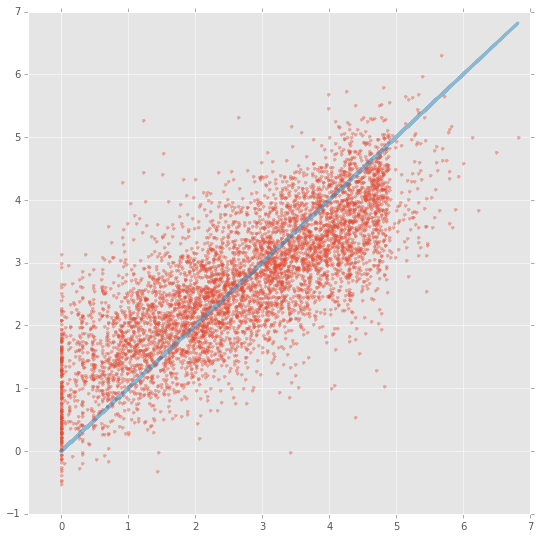

In [16]:
plt.figure(figsize=(9,9))
y_pred_test=bst.predict(dtest)
plt.plot(y_test,y_pred_test,'.',alpha=0.4)
plt.plot(y_test,y_test,lw=3,alpha=0.5)
plt.xlim(xmin=-0.5)
from scipy.stats import pearsonr
print pearsonr(y_test,y_pred_test)